<a href="https://colab.research.google.com/github/pparutto/BINF2025_TP7/blob/main/BINF2025_TP7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BINF TP7 : analyse d'équilibre de flux métaboliques - FBA

Comme toutes les réactions métaboliques d'un organisme sont liées entre elles par leurs substrats / produits / cofacteurs, il est nécessaire de modéliser toutes les réactions d'un même organisme simultanément pour comprendre son métabolisme. On peut alors chercher quelles sont les réactions limitantes la production de certains composés ou la croissance d'un l'organisme.

Une telle méthode est l'analyse d'équilibre des fluxs métaboliques (Flux Balance Analysis -FBA) consistant à étudier le taux (flux) de matière passant au travers de chaque réactions métabolique d'un organisme.

L'élément de base de la FBA est une matrice de stoichiométrie $S$ décrivant les différentes réactions présentes dans un organisme. Chaque ligne représente un composé et chaque colonne une réaction, une valeur positive dans la matrice signifie que la réaction produit le composé correspondant et une valeur négative qu'elle le consomme.

Basé sur cette matrice, on cherche à trouver la distribution des flux de matière $v$ au travers de chaque réaction du réseau en considérant que le système est à l'équilibre

$Sv = 0$.

Cette hypothèse évite d'avoir à modéliser la dynamique des différentes réactions. A partir de là, on va résoudre ce système d'équations linéaires pour trouver $v$. Le problème est que le système est sous-spécifié car il possède plus de variables (réactions) que d'équations (composés). Il n'existe donc pas une unique solution. On va alors introduire un nouvel élément: une fonction objectif $f$ et chercher la distribution des flux maximisant $f$. La fonction $f$ est définie comme une combinaison linéaire des fluxs :

$$f = \sum\limits_{i=0}^N a_i v_i$$

où $a_i$ est un coefficient décrivant le poids du flux $v_i$ dans la fonction objectif. En particulier, on va souvent utiliser une fonction modélisant le taux de croissance de l'organisme, basée sur les réactions nécessaire à sa croissance. On peut alors résoudre le système par programation linéaire avec $f$ pour fonction objectif et un ensemble de contraintes de valeurs min et max des fluxs.

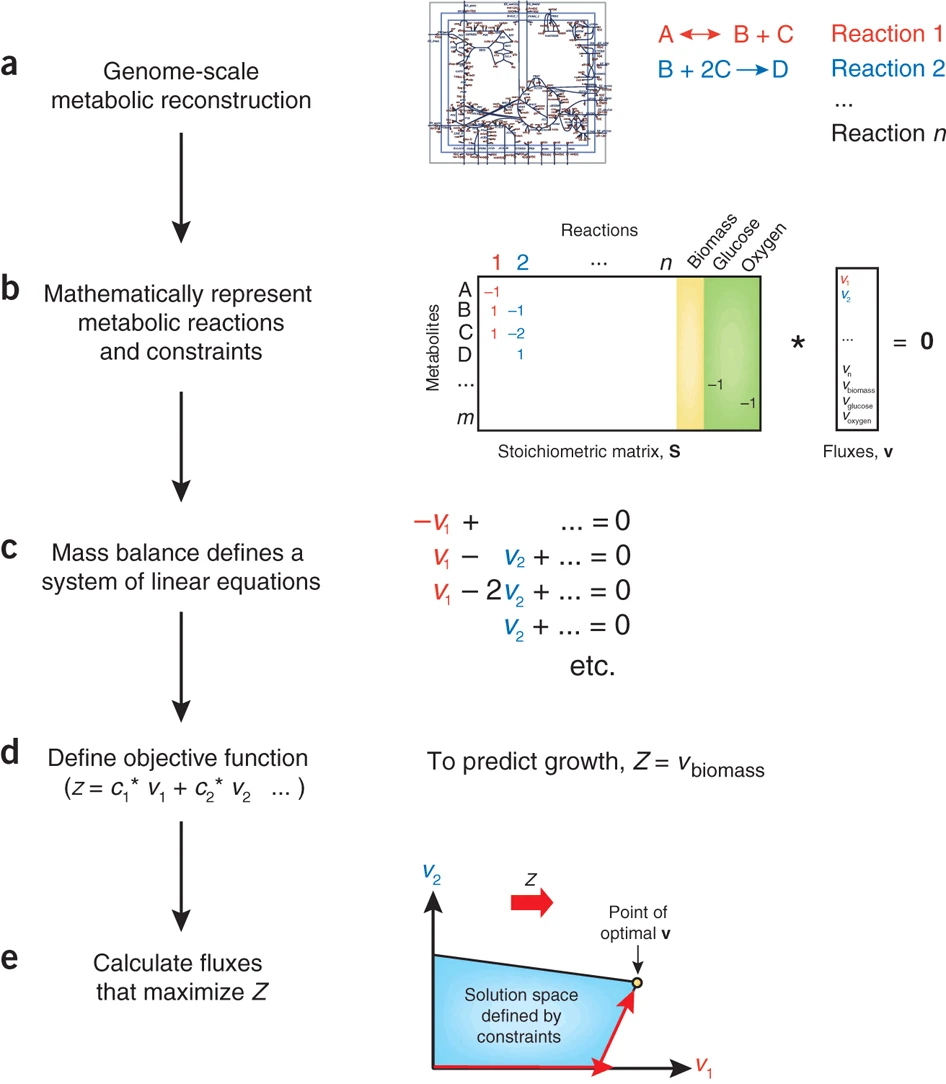

Pour ce TP, nous allons utiliser cobrapy pour optimiser les flux métaboliques et escher pour la visualisation. Installez ces packages via pip :

In [1]:
!pip install cobra escher

  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.6 MB/s eta 0:00:00
Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64

## Exercice 1 : Affichage et caractéristiques d'un modèle

Commençons par vérifier que tout fonctionne correctement:


1. Téléchargez la carte Escher du modèle « e_coli_core » depuis la base de données [BiGG](http://bigg.ucsd.edu).
2. Chargez cette carte via Escher en Python. Regardez la documentation ici : https://escher.readthedocs.io/en/latest/escher-python.html

In [27]:
import escher
from escher import Builder, plots
import cobra
from cobra.io import load_model
from time import sleep

model = cobra.io.read_sbml_model("e_coli_core.xml")
builder = Builder(model=model, map_name='e_coli_core.Core metabolism')
builder

Builder()

3. Sauvegardez un fichier html de cette carte et l’ouvrir dans un navigateur.

In [28]:
builder.save_html("e_coli_core.html")

4.	Qu’observez-vous ?

Une jolie carte avec beaucoup d'embranchement.

5. Combien de métabolites du sont présents dans le modèle ?

In [33]:
print(f"metabolites = {len(model.metabolites)}")

metabolites = 72


6. Combien de réactions ?

In [47]:
print(f"reactions = {len(model.reactions)}")

reactions = 95


7. Quel est le nom du métabolite qui participe au plus de réactions en tant que substrat ?

In [56]:
def get_max_reaction_as_substrat(model):
    max_count = 0
    max_metabolite = None

    for metabolite in model.metabolites:
        count = 0
        for reaction in model.reactions:
            if metabolite in reaction.metabolites and reaction.metabolites[metabolite] < 0:
                count += 1
        if count > max_count:
            max_count = count
            max_metabolite = metabolite
    name = model.metabolites.get_by_id(max_metabolite.id).name
    return name

name = get_max_reaction_as_substrat(model)
print(f"Nom du métabolisme le plus présent en tant que substrat: {name}")

Nom du métabolisme le plus présent en tant que substrat: H+


8. Quel est le nom du métabolite qui participe au plus de réactions en tant que produit ?

In [57]:
def get_name_max_reaction_as_product(model):
    max_count = 0
    max_metabolite = None

    for metabolite in model.metabolites:
        count = 0
        for reaction in model.reactions:
            if metabolite in reaction.metabolites and reaction.metabolites[metabolite] > 0:
                count += 1
        if count > max_count:
            max_count = count
            max_metabolite = metabolite
    name = model.metabolites.get_by_id(max_metabolite.id).name
    return name

name = get_name_max_reaction_as_product(model)
print(f"Nom du métabolisme le plus présent : {name}")

Nom du métabolisme le plus présent : H+


9. Affichez un histogramme présentant la distribution du nombre de réaction auquel participe chaque métabolite.

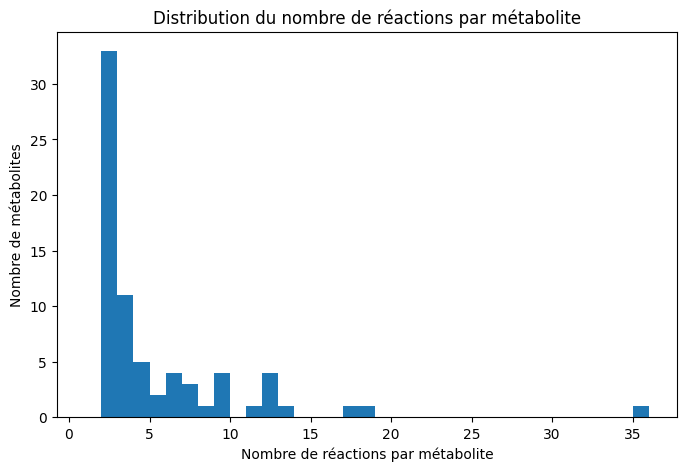

In [61]:
import matplotlib.pyplot as plt

reaction_counts = [len(reaction.reactions) for reaction in model.metabolites]

plt.figure(figsize=(8, 5))
plt.hist(reaction_counts, bins=range(1, max(reaction_counts) + 2))
plt.xlabel("Nombre de réactions par métabolite")
plt.ylabel("Nombre de métabolites")
plt.title("Distribution du nombre de réactions par métabolite")
plt.show()


## Exercice 2 : visualisation des flux métaboliques

Pour obtenir la distribution des flux métaboliques à partir d'un modèle, il faut choisir une fonction à optimiser. Cette fonction est une somme pondérée de concentrations de métabolites et l'on va chercher les flux au travers des réactions permettant de maximiser cette fonction. Pour étudier la capacité naturelle du métabolisme d'un organisme est une fonction représentant sa croissance.

1.	Téléchargez dans BiGG le modèle « e_coli_core » au format sbml associé à la carte que vous avez téléchargé dans la partie 1.
2. Chargez le modèle via Escher.

In [62]:
import escher
from escher import Builder, plots
import cobra
from cobra.io import load_model
from time import sleep

model = cobra.io.read_sbml_model("e_coli_core.xml")
builder = Builder(model=model, map_name='e_coli_core.Core metabolism')
builder

Builder()

3. Optimisez les flux pour la fonction de croissance standard du modèle.

In [63]:
solution = model.optimize()
print(f"Solution: {solution.objective_value}")

Solution: 0.8739215069684295


5.	Affichez les flux sur la carte du modèle :

In [64]:
builder.reaction_data = solution.fluxes
builder.metabolite_data = solution.shadow_prices

6.	Sauvegardez la carte au format HTML.

In [65]:
builder.save_html("e_coli_core_optimized.html")

7.	Qu’observez-vous sur cette carte maintenant ?

Les réactions du métabolisme central sont colorées. L'épaisseur et la couleur des flèches indique l'intensité du flux dans chaque réaction. Certaines voies sont très utilisées et d'autres le sont très peu. 
On peut voir les réactions qui sont les plus actives pour maximiser la croissance d'E. coli. 

## Exercice 3 : etude de l'impact du milieu de culture sur la croissance d'E.coli

On va utiliser la FBA pour estimer l’impact de différents constituants du milieu de culture sur le taux de croissance d'E.coli. On peut avoir accès aux composés du milieu de culture dans notre modèle via l'attribut model.medium.

1. Trouver le composé du milieu correspondant au glucose et affichez un graphique présentant le taux de production de biomasse en fonction de la quantité de glucose dans le milieu de 1 à 1500.

Attention quand vous récuperrez le dictionnaire model.medium retourne une copie du dictionnaire du modèle, donc mod.medium["Ex_o2_e"] = 5 ne fait rien. A l’inverse, vous devez récupérer le dico, le modifier et le ré-affecter au modèle.

In [73]:
# import des librairies 
import numpy as np
import matplotlib.pyplot as plt

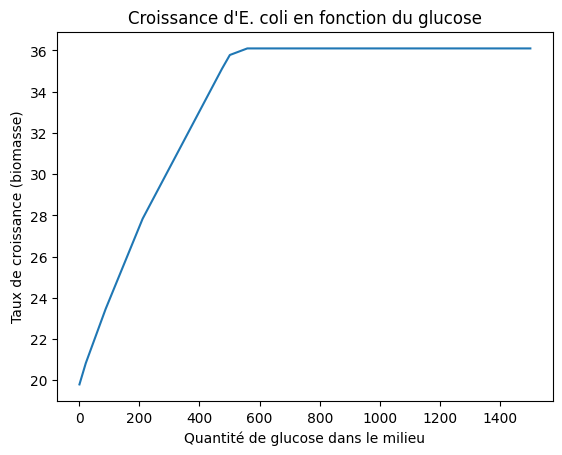

In [74]:
glucose_range = np.arange(1, 1501)
growth_rates = []

for glc in glucose_range:
    medium = model.medium
    medium["EX_glc__D_e"] = glc
    model.medium = medium
    sol = model.optimize()
    growth_rates.append(sol.objective_value)

plt.plot(glucose_range, growth_rates)
plt.xlabel("Quantité de glucose dans le milieu")
plt.ylabel("Taux de croissance (biomasse)")
plt.title("Croissance d'E. coli en fonction du glucose")
plt.show()

2.	On va changer la source d’énergie en replaçant le glucose par du lactose dans le milieu de culture. Affichez la courbe du taux de production de biomasse en fonction de la quantité de lactose dans le milieu de 1 et 1500 en absence de glucose.

/home/florestan/S8/BINF/BINF2025_TP7/.venv/lib/python3.12/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


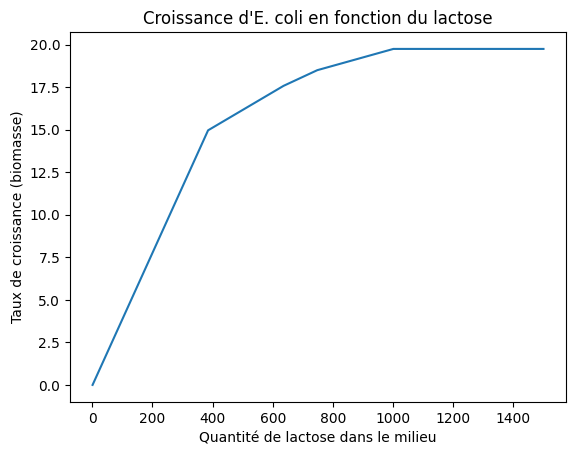

In [76]:
lactose_range = np.arange(1, 1501)
growth_rates_lac = []

for lac in lactose_range:
    medium = model.medium
    medium["EX_glc__D_e"] = 0  # pas de glucose
    medium["EX_lac__D_e"] = lac
    model.medium = medium
    sol = model.optimize()
    growth_rates_lac.append(sol.objective_value)

plt.plot(lactose_range, growth_rates_lac)
plt.xlabel("Quantité de lactose dans le milieu")
plt.ylabel("Taux de croissance (biomasse)")
plt.title("Croissance d'E. coli en fonction du lactose")
plt.show()

3. Comparez les courbes des questions 1 et 2.

Les deux courbes montrent une croissance qui augmente rapidement avec la concentration de substrat (glucose ou lactose) puis atteint un plateau.  
La croissance maximale obtenue avec le glucose est légèrement supérieure à celle obtenue avec le lactose.  
De plus, la courbe du glucose atteint son plateau pour une concentration plus faible que celle du lactose, ce qui indique que le glucose est utilisé plus efficacement comme source de carbone et d'énergie.

4. On va maintenant se placer en condition anaérobique en supprimant l’oxygène du milieu de culture. Générez les courbes de croissance correspondante pour un milieu contenant uniquement du glucose ou du lactose (comme aux questions 1 et 2).

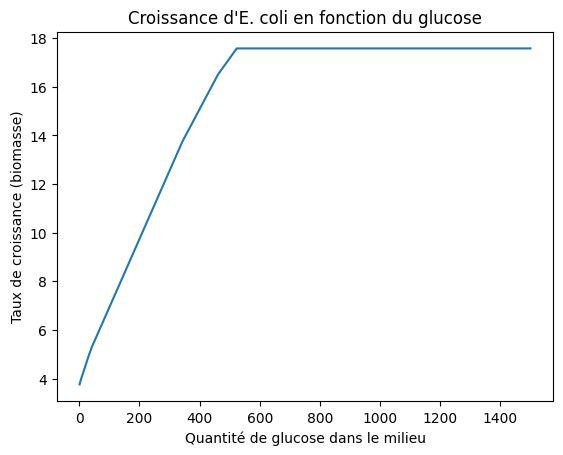

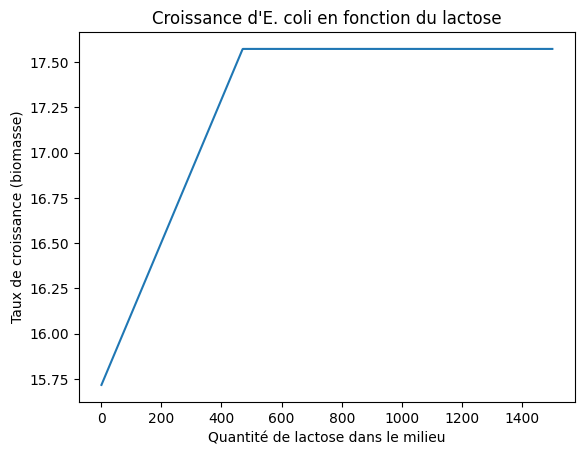

In [77]:
# graphique de la croissance d'E. coli en fonction du glucose
glucose_range = np.arange(1, 1501)
growth_rates = []

for glc in glucose_range:
    medium = model.medium
    medium["EX_o2_e"] = 0  # pas d'oxygène
    medium["EX_glc__D_e"] = glc
    model.medium = medium
    sol = model.optimize()
    growth_rates.append(sol.objective_value)

plt.plot(glucose_range, growth_rates)
plt.xlabel("Quantité de glucose dans le milieu")
plt.ylabel("Taux de croissance (biomasse)")
plt.title("Croissance d'E. coli en fonction du glucose")
plt.show()

# graphique de la croissance d'E. coli en fonction du lactose
lactose_range = np.arange(1, 1501)
growth_rates_lac = []

for lac in lactose_range:
    medium = model.medium
    medium["EX_o2_e"] = 0  # pas d'oxygène
    medium["EX_lac__D_e"] = lac
    model.medium = medium
    sol = model.optimize()
    growth_rates_lac.append(sol.objective_value)

plt.plot(lactose_range, growth_rates_lac)
plt.xlabel("Quantité de lactose dans le milieu")
plt.ylabel("Taux de croissance (biomasse)")
plt.title("Croissance d'E. coli en fonction du lactose")
plt.show()

Comparez les courbes des questions 1,2 et 4.

Dans des conditions d'anaérobie, la croissance d'E. coli est très réduite, que ce soit avec le glucose ou le lactose. 
Pour les deux courbes, le plateau est atteint pour des concentrations de substrats plus élevées et le taux de croissance maximal est beaucoup plus faible que dans un milieu avec de l'oxygène. 
On peut en conclure que l'oxygène est important pour permettre une croissance d'E. coli plus efficace.

# Exercice 4 : étude de l'effet de la suppression de gènes

Nous allons maintenant l'impacte de l'absence d'une enzyme sur le taux de croissance d'E.coli. Comme vu en cours, l'absence d'une enzyme implique la disparition de la réaction qu'elle catalyse.

1.	Pour chaque réaction du modèle, calculez le taux de production de biomasse après suppression de celle-ci.

In [ ]:
print("Votre code ici !!")

2.	Affichez les résultats sous forme d’un barplot où l'axe x contient chaque réaction supprimée et l'axe y le tau de prodution de biomasse associée.

In [ ]:
print("Votre code ici !!")

3.	Qu’observez-vous ? Quels sont les réactions nécessaires à la croissance ? Pouvez-vous comprendre pourquoi ?

**Votre réponse ici !!**

4.	Une réaction a un effet particulier, quelle est-elle et pouvez-vous pourquoi elle a cet effet ?

**Votre réponse ici !!**

## Exercice 5 : optimisation de la production d’un composé

Jusqu'à maintenant, on a considéré la fonction de création de biomasse (modélisant la croissance) comme fonction à optimisé. Cela nous a permi d'étudier le métabolisme naturel d'E.coli. On va maintenant se placer dans un cadre biotechnologique où on veut utiliser E.coli pour produire un composé d'intérêt.

On va utiliser le modèle métabolique étendu d'E.coli qui donne accès à un plus grand nombre de composés et réactions. Jusqu'à maintenant, nous avions utilisé le modèle "core" qui correspond uniquement au métabolisme central.

1.	Téléchargez et utilisez le modèle depuis iAF1260 BiGG.

In [ ]:
print("Votre code ici !!")

2.	Optimisez les flux métaboliques pour la fonction objectif du taux de production de biomasse. Quelle valeur obtenez-vous ?

In [ ]:
print("Votre code ici !!")

3.	On va maintenant chercher à maximiser la production de la molécule enterochelin (équivalente à l'enterobactine). Qu’est-ce que l’enterobactine ?

**Votre réponse ici !!**

4.	Trouvez la réaction produisant l’enterochelin dans le modèle.

In [ ]:
print("Votre code ici !!")

5.	Remplacez la fonction objectif du modèle par une fonction optimisant uniquement cette réaction.

In [ ]:
print("Votre code ici !!")

4.	Affichez la courbe d'évolution du taux de production d’enterochelin en fonction de la concentration en glucose dans le milieu entre 1 et 1500.

In [ ]:
print("Votre code ici !!")